In [1]:
import os
import numpy as np
import xarray as xr
from xhistogram.xarray import histogram
from cmocean import cm

from matplotlib import pyplot as plt
%matplotlib inline

import mitequinox.utils as ut
import mitequinox.plot as pl

In [2]:
if True:
    from dask.distributed import Client, LocalCluster
    from dask_jobqueue import PBSCluster
    #cluster = PBSCluster()
    cluster = PBSCluster(cores=28, processes=14) # necessary?
    w = cluster.scale(jobs=20)
    client = Client(cluster)
    client
else:
    from dask.distributed import Client, LocalCluster
    #
    cluster = LocalCluster()
    client = Client(cluster)
    client

In [5]:
client

Client Scheduler: tcp://10.148.1.71:56775 Dashboard: http://10.148.1.71:8787/status,Cluster Workers: 196 Cores: 392 Memory: 1.53 TiB


## Store

In [6]:
# same but over all variables and faces
V = ["Eta", "SSU", "SSV", "SST", "SSS"]
V = ["Eta"]

#V = V+["KPPhbl", "qsoceTAUX", "oceTAUY"]

In [7]:
def compute_store(v, ds, diag, op):
    #i, j = ut.get_ij_dims(ds)
    diag_zarr = diag+"_"+v
    if not ut.is_diagnostic(diag_zarr):
        out, tmp_zarr = ut.custom_distribute(ds, op, 
                                             tmp_dir=ut.scratch+"tmp/", 
                                             face=1, ) # **{j: 1080}
        ut.store_diagnostic(diag_zarr, out, overwrite=True)
        print("{} {} stored".format(v, diag))
    else:
        print("{} {} already exists".format(v, diag))

In [8]:
ref_data_dir = "/dataref/ocean-analysis/intranet/LLC4320_surface/"

diags = {"mean2": lambda x: x.mean("time"),
         "mean_square2": lambda x: (x**2).mean("time"),
        }
        
for v in V:
    #ds = ut.load_data(v)
    ds = xr.open_zarr(ref_data_dir + v + ".zarr").isel()
    for diag, op in diags.items():
        compute_store(v, ds, diag, op)

KeyboardInterrupt: 

In [9]:
ds

<xarray.Dataset>
Dimensions:  (face: 13, i: 4320, j: 4320, time: 10311)
Coordinates:
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * i        (i) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
  * j        (j) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
    niter    (time) int64 dask.array<chunksize=(200,), meta=np.ndarray>
  * time     (time) datetime64[ns] 2011-09-13 ... 2012-11-15T14:00:00
Data variables:
    Eta      (time, face, j, i) float32 dask.array<chunksize=(1, 1, 4320, 4320), meta=np.ndarray>

In [31]:
diags = {"var": lambda x: x.var("time"),
        }
        
for v in V:
    #ds = ut.load_data(v)
    ds = xr.open_zarr(ref_data_dir + v + ".zarr")
    for diag, op in diags.items():
        compute_store(v, ds, diag, op)

distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting


KilledWorker: ("('xarray-Eta-getitem-88a44cd741f864e2a1fe46007e74fc9a', 496, 0, 0, 0)", <Worker 'tcp://127.0.0.1:49216', name: 2, memory: 0, processing: 1590>)

# Read Eulerian mean fields (at model grids)

In [16]:
# load diagnostics
V = ["Eta", "SSU", "SSV", "SST", "SSS"]
D = ["mean", "mean_square"]
ds = xr.merge([ut.load_diagnostic(d+"_"+v).rename({v:d+"_"+v}) 
               for v in V for d in D])

grid = xr.open_zarr('/home1/datawork/xyu/grid/mit_grid.zarr')
ds = xr.merge([ds,grid])
ds = ds.isel(i = slice(0,None,4), j = slice(0,None,4), i_g = slice(0,None,4), j_g = slice(0,None,4))
ds['lon'] = 0*ds.face+ds.XC
ds['lat'] = 0*ds.face+ds.YC
ds
#ds.load()

<xarray.Dataset>
Dimensions:          (face: 13, i: 1080, i_g: 1080, j: 1080, j_g: 1080)
Coordinates: (12/20)
  * face             (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * i                (i) int64 0 4 8 12 16 20 ... 4296 4300 4304 4308 4312 4316
  * j                (j) int64 0 4 8 12 16 20 ... 4296 4300 4304 4308 4312 4316
  * i_g              (i_g) int64 0 4 8 12 16 20 ... 4300 4304 4308 4312 4316
  * j_g              (j_g) int64 0 4 8 12 16 20 ... 4300 4304 4308 4312 4316
    CS               (face, j, i) float32 dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>
    ...               ...
    dyC              (face, j_g, i) float32 dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>
    dyG              (face, j, i_g) float32 dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>
    rA               (face, j, i) float32 dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>
    rAs              (face, j_g, i) float32 dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>
    rAw              (face, j, i_g) float32 dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>
    rAz              (face, j_g, i_g) float32 dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>
Data variables:
    mean_Eta         (face, j, i) float32 dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>
    mean_square_Eta  (face, j, i) float32 dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>
    mean_SSU         (face, j, i_g) float32 dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>
    mean_square_SSU  (face, j, i_g) float32 dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>
    mean_SSV         (face, j_g, i) float32 dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>
    mean_square_SSV  (face, j_g, i) float32 dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>
    mean_SST         (face, j, i) float32 dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>
    mean_square_SST  (face, j, i) float32 dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>
    mean_SSS         (face, j, i) float32 dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>
    mean_square_SSS  (face, j, i) float32 dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>
    lon              (face, j, i) float64 dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>
    lat              (face, j, i) float64 dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>

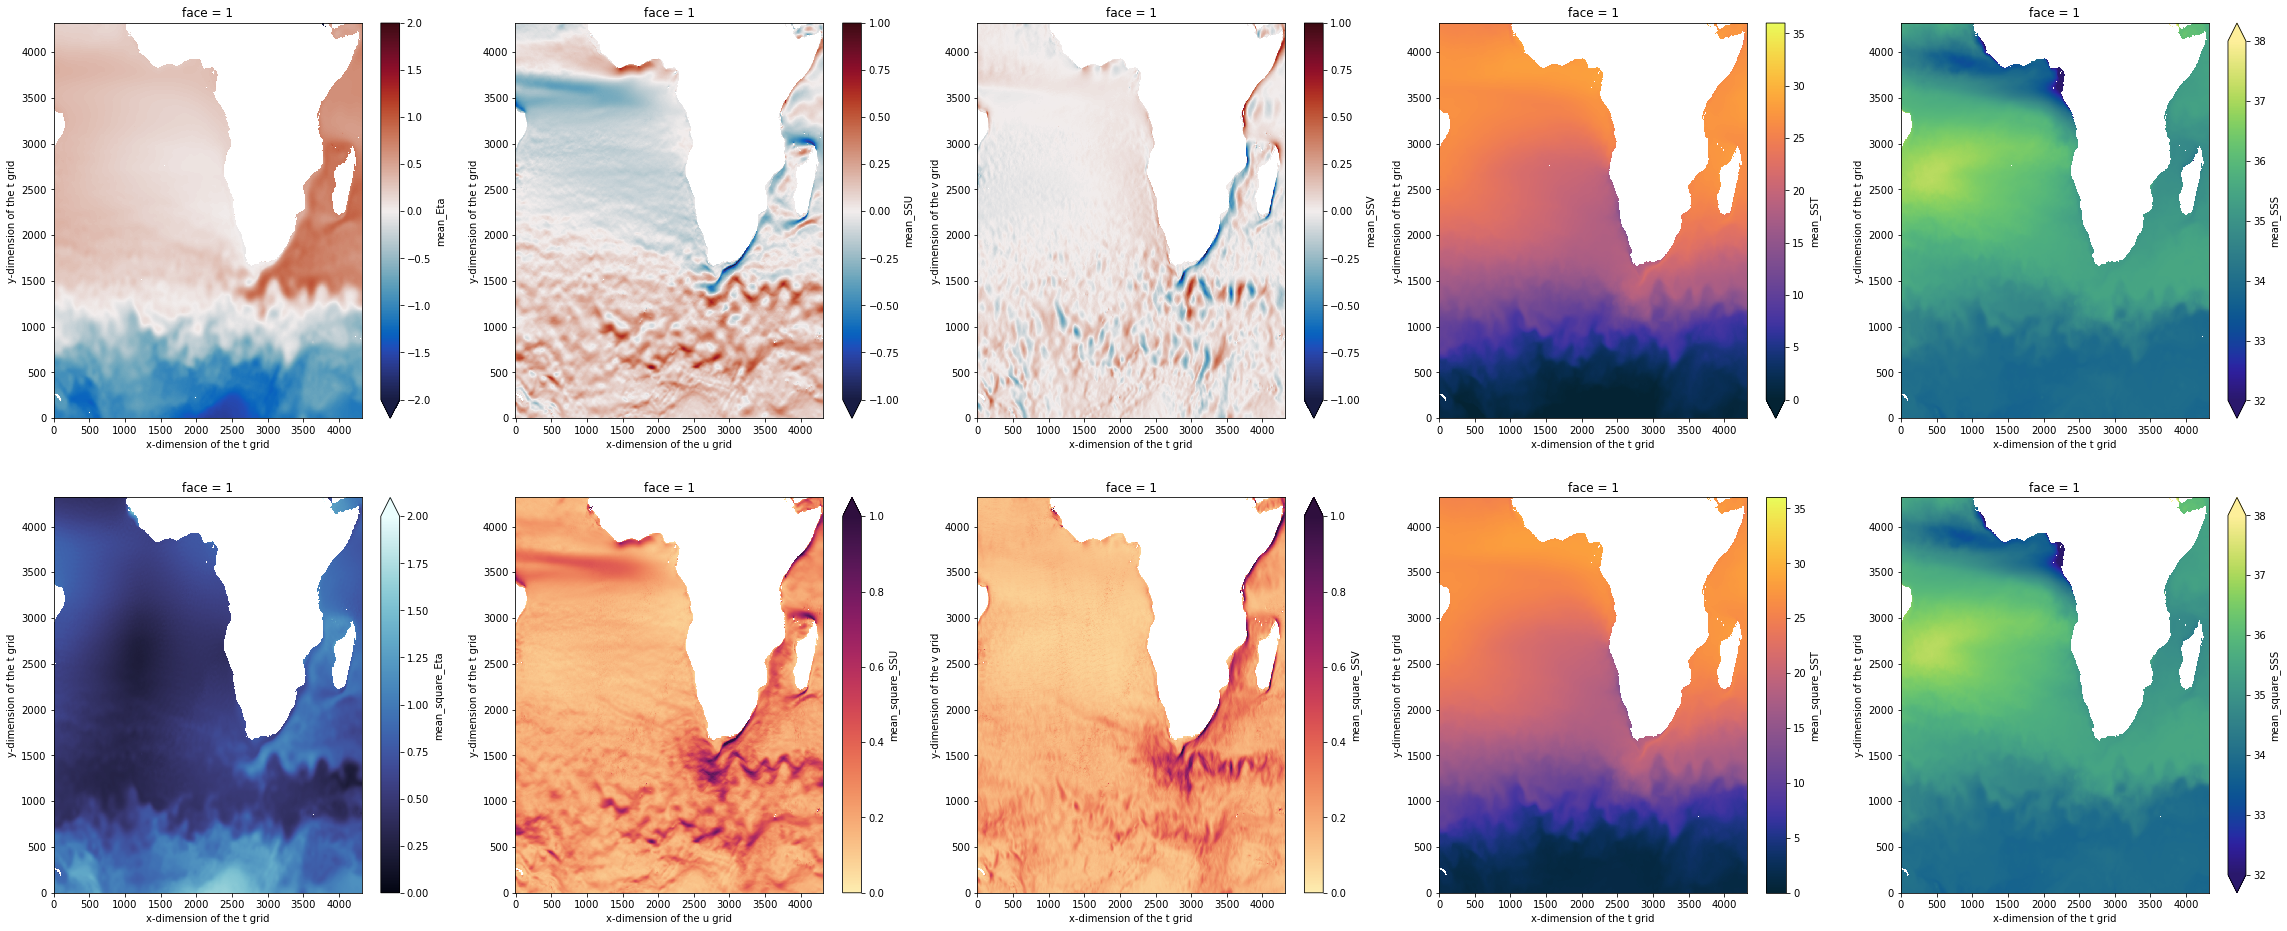

In [76]:
fig, ax = plt.subplots(figsize=(40,16))

ax = plt.subplot(251)
ds.mean_Eta.isel(face=1).plot(vmin=-2,vmax=2,cmap=cm.balance)

ax = plt.subplot(252)
ds.mean_SSU.isel(face=1).plot(vmin=-1,vmax=1,cmap=cm.balance)

ax = plt.subplot(253)
ds.mean_SSV.isel(face=1).plot(vmin=-1,vmax=1,cmap=cm.balance)

ax = plt.subplot(254)
ds.mean_SST.isel(face=1).plot(vmin=0,vmax=36,cmap=cm.thermal)

ax = plt.subplot(255)
ds.mean_SSS.isel(face=1).plot(vmin=32,vmax=38,cmap=cm.haline)

ax = plt.subplot(256)
np.sqrt(ds.mean_square_Eta.isel(face=1)).plot(vmin=0,vmax=2,cmap=cm.ice)

ax = plt.subplot(257)
np.sqrt(ds.mean_square_SSU.isel(face=1)).plot(vmin=0,vmax=1,cmap=cm.matter)

ax = plt.subplot(258)
np.sqrt(ds.mean_square_SSV.isel(face=1)).plot(vmin=0,vmax=1,cmap=cm.matter)

ax = plt.subplot(259)
np.sqrt(ds.mean_square_SST.isel(face=1)).plot(vmin=0,vmax=36,cmap=cm.thermal)

ax = plt.subplot(2,5,10)
np.sqrt(ds.mean_square_SSS.isel(face=1)).plot(vmin=32,vmax=38,cmap=cm.haline)

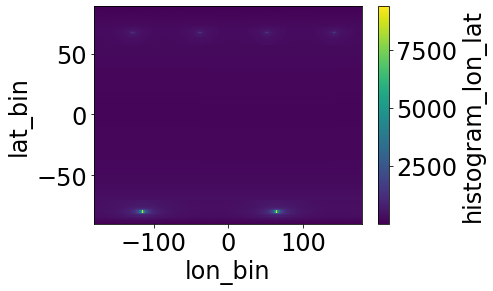

In [26]:
#dl = 0.1
dl = 1
lon = np.arange(-180.,180., dl)
lat = np.arange(-90., 90., dl)

N = histogram(ds.lon, ds.lat, bins=[lon, lat], dim=['i', 'j', 'face'], block_size=None)
N.plot(x='lon_bin',y='lat_bin')

In [28]:
E_KE = histogram(ds.lon, ds.lat, 
                 bins=[lon, lat], 
                 weights= (ds.mean_square_SSU.rename({'i_g': 'i'}) + ds.mean_square_SSV.rename({'j_g': 'j'})), 
                 dim=['i', 'j','face'],
                 block_size=None
                )
E_KE_mean = (E_KE/N).rename('E_KE_mean').rename({'lon_bin': 'lon','lat_bin': 'lat'})

In [30]:
E_Eta = histogram(ds.lon, ds.lat, 
                  bins=[lon, lat], 
                  weights= ds.mean_Eta, 
                  dim=['i', 'j','face'],
                  block_size=None
                 )
E_Eta_mean = (E_Eta/N).rename('E_Eta_mean').rename({'lon_bin': 'lon','lat_bin': 'lat'})

In [31]:
E_SST = histogram(ds.lon, ds.lat, 
                  bins=[lon, lat], 
                  weights= ds.mean_SST, 
                  dim=['i', 'j','face'],
                  block_size=None
                 )
E_SST_mean = (E_SST/N).rename('E_SST_mean').rename({'lon_bin': 'lon','lat_bin': 'lat'})

In [32]:
E_SSS = histogram(ds.lon, ds.lat, 
                  bins=[lon, lat], 
                  weights= ds.mean_SSS, 
                  dim=['i', 'j','face'],
                  block_size=None
                 )
E_SSS_mean = (E_SSS/N).rename('E_SSS_mean').rename({'lon_bin': 'lon','lat_bin': 'lat'})

In [34]:
E = xr.merge([E_KE_mean,E_Eta_mean,E_SST_mean,E_SSS_mean])
E

<xarray.Dataset>
Dimensions:     (lat: 179, lon: 359)
Coordinates:
  * lon         (lon) float64 -179.5 -178.5 -177.5 -176.5 ... 176.5 177.5 178.5
  * lat         (lat) float64 -89.5 -88.5 -87.5 -86.5 ... 85.5 86.5 87.5 88.5
Data variables:
    E_KE_mean   (lon, lat) float64 nan nan nan ... 0.004558 0.003829 0.006418
    E_Eta_mean  (lon, lat) float64 nan nan nan nan ... -1.682 -1.75 -1.688
    E_SST_mean  (lon, lat) float64 nan nan nan nan ... -1.561 -1.558 -1.569
    E_SSS_mean  (lon, lat) float64 nan nan nan nan ... 28.66 28.73 28.68 28.92

In [35]:
E.to_zarr(os.path.join(ut.root_data_dir,'diags/E_mean.zarr'), mode='w')

# load 1-degree binned Eulerian mean

In [17]:
E = xr.open_zarr(os.path.join(ut.root_data_dir,'diags/E_mean.zarr'))
E

<xarray.Dataset>
Dimensions:     (lat: 179, lon: 359)
Coordinates:
  * lat         (lat) float64 -89.5 -88.5 -87.5 -86.5 ... 85.5 86.5 87.5 88.5
  * lon         (lon) float64 -179.5 -178.5 -177.5 -176.5 ... 176.5 177.5 178.5
Data variables:
    E_Eta_mean  (lon, lat) float64 dask.array<chunksize=(180, 179), meta=np.ndarray>
    E_KE_mean   (lon, lat) float64 dask.array<chunksize=(180, 179), meta=np.ndarray>
    E_SSS_mean  (lon, lat) float64 dask.array<chunksize=(180, 179), meta=np.ndarray>
    E_SST_mean  (lon, lat) float64 dask.array<chunksize=(180, 179), meta=np.ndarray>

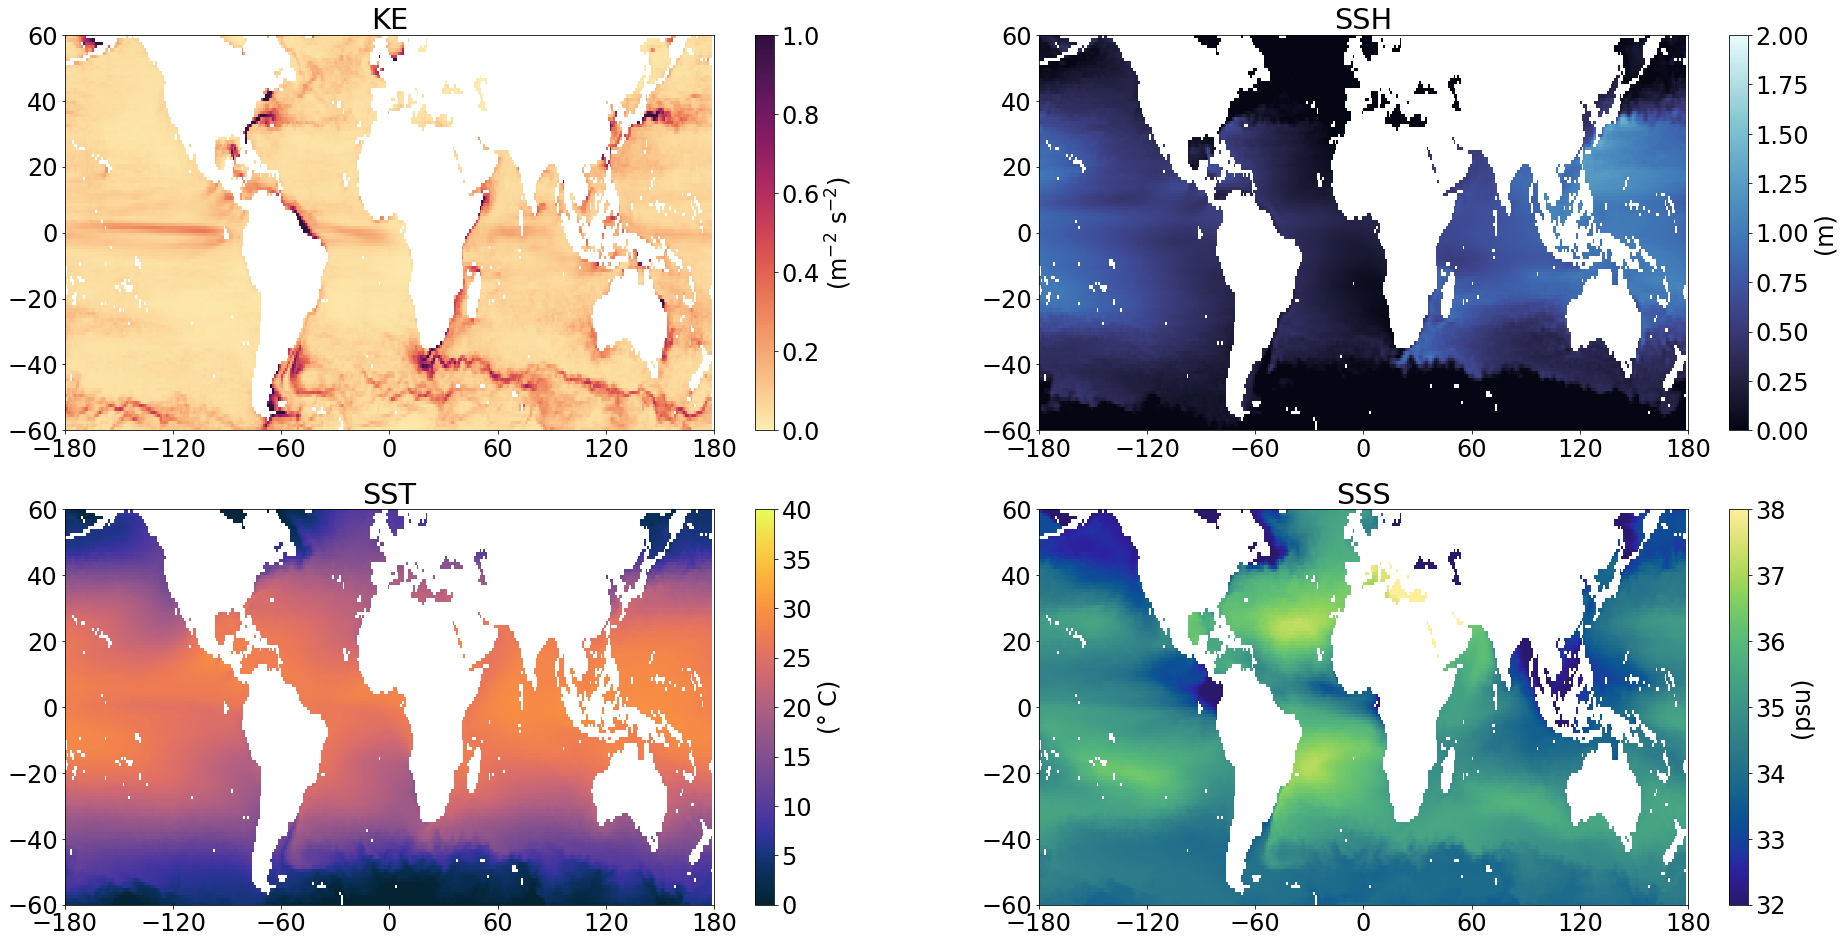

In [37]:
plt.rc('font', size=24) 
font_size=24


fig, ax = plt.subplots(figsize=(32,16))

ax = plt.subplot(221)
cax = (E.E_KE_mean).plot(x='lon',y='lat',vmin=0,vmax=1,cmap=cm.matter, add_colorbar = False)
cbar = plt.colorbar(cax, ax=ax, extend=None, orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('(m$^{-2}$ s$^{-2}$)', fontsize=font_size)
ax.set_xlim([-180,180])
ax.set_ylim([-60., 60.])
ax.set_xticks([-180, -120,-60, 0, 60, 120, 180])
ax.set_yticks([-60, -40, -20, 0, 20, 40, 60])
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_title('KE')

ax = plt.subplot(222)
cax = (E.E_Eta_mean).plot(x='lon',y='lat',vmin=0,vmax=2,cmap=cm.ice, add_colorbar = False)
cbar = plt.colorbar(cax, ax=ax, extend=None, orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('(m)', fontsize=font_size)
ax.set_xlim([-180,180])
ax.set_ylim([-60., 60.])
ax.set_xticks([-180, -120,-60, 0, 60, 120, 180])
ax.set_yticks([-60, -40, -20, 0, 20, 40, 60])
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_title('SSH')

ax = plt.subplot(223)
cax = (E.E_SST_mean).plot(x='lon',y='lat',vmin=0,vmax=40,cmap=cm.thermal, add_colorbar = False)
cbar = plt.colorbar(cax, ax=ax, extend=None, orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('($\degree$ C)', fontsize=font_size)
ax.set_xlim([-180,180])
ax.set_ylim([-60., 60.])
ax.set_xticks([-180, -120,-60, 0, 60, 120, 180])
ax.set_yticks([-60, -40, -20, 0, 20, 40, 60])
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_title('SST')

ax = plt.subplot(224)
cax = (E.E_SSS_mean).plot(x='lon',y='lat',vmin=32,vmax=38,cmap=cm.haline, add_colorbar = False)
cbar = plt.colorbar(cax, ax=ax, extend=None, orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('(psu)', fontsize=font_size)
ax.set_xlim([-180,180])
ax.set_ylim([-60., 60.])
ax.set_xticks([-180, -120,-60, 0, 60, 120, 180])
ax.set_yticks([-60, -40, -20, 0, 20, 40, 60])
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_title('SSS')

plt.savefig('/home1/datahome/xyu/equinox_working/Lagrangian_vs_Eulerian_LLC4320/Figures/Eulerian_mean_1degree.png')

______________
# Lagrangian mean from Zoé

In [38]:
import pandas as pd
import mitequinox.parcels as pa

root_dir = '/home1/datawork/aponte/parcels/'
run_name = 'global_extra_T365j_dt1j_dij50'
p = pa.parcels_output(root_dir+run_name,parquets=['time'])
ds_L = p.load_diagnostic('L_mean_std.zarr')
ds_L

INFO: Compiled ParcelsRandom ==> /dev/shm/pbs.4240720.datarmor0/parcels-502027/libparcels_random_7a59ca6c-cc3a-4b72-b09a-8c8d40c33992.so


<xarray.Dataset>
Dimensions:                   (lat: 179, lon: 359)
Coordinates:
  * lat                       (lat) float64 -89.5 -88.5 -87.5 ... 86.5 87.5 88.5
  * lon                       (lon) float64 -179.5 -178.5 -177.5 ... 177.5 178.5
Data variables: (12/14)
    area_mean                 (lon, lat) float64 dask.array<chunksize=(180, 179), meta=np.ndarray>
    area_std                  (lon, lat) float64 dask.array<chunksize=(180, 179), meta=np.ndarray>
    meridional_velocity_mean  (lon, lat) float64 dask.array<chunksize=(180, 179), meta=np.ndarray>
    meridional_velocity_std   (lon, lat) float64 dask.array<chunksize=(180, 179), meta=np.ndarray>
    salinity_mean             (lon, lat) float64 dask.array<chunksize=(180, 179), meta=np.ndarray>
    salinity_std              (lon, lat) float64 dask.array<chunksize=(180, 179), meta=np.ndarray>
    ...                        ...
    temperature_mean          (lon, lat) float64 dask.array<chunksize=(180, 179), meta=np.ndarray>
    temperature_std           (lon, lat) float64 dask.array<chunksize=(180, 179), meta=np.ndarray>
    velocity_amplitude_mean   (lon, lat) float64 dask.array<chunksize=(180, 179), meta=np.ndarray>
    velocity_amplitude_std    (lon, lat) float64 dask.array<chunksize=(180, 179), meta=np.ndarray>
    zonal_velocity_mean       (lon, lat) float64 dask.array<chunksize=(180, 179), meta=np.ndarray>
    zonal_velocity_std        (lon, lat) float64 dask.array<chunksize=(180, 179), meta=np.ndarray>

# Eulerian vs Lagrangian

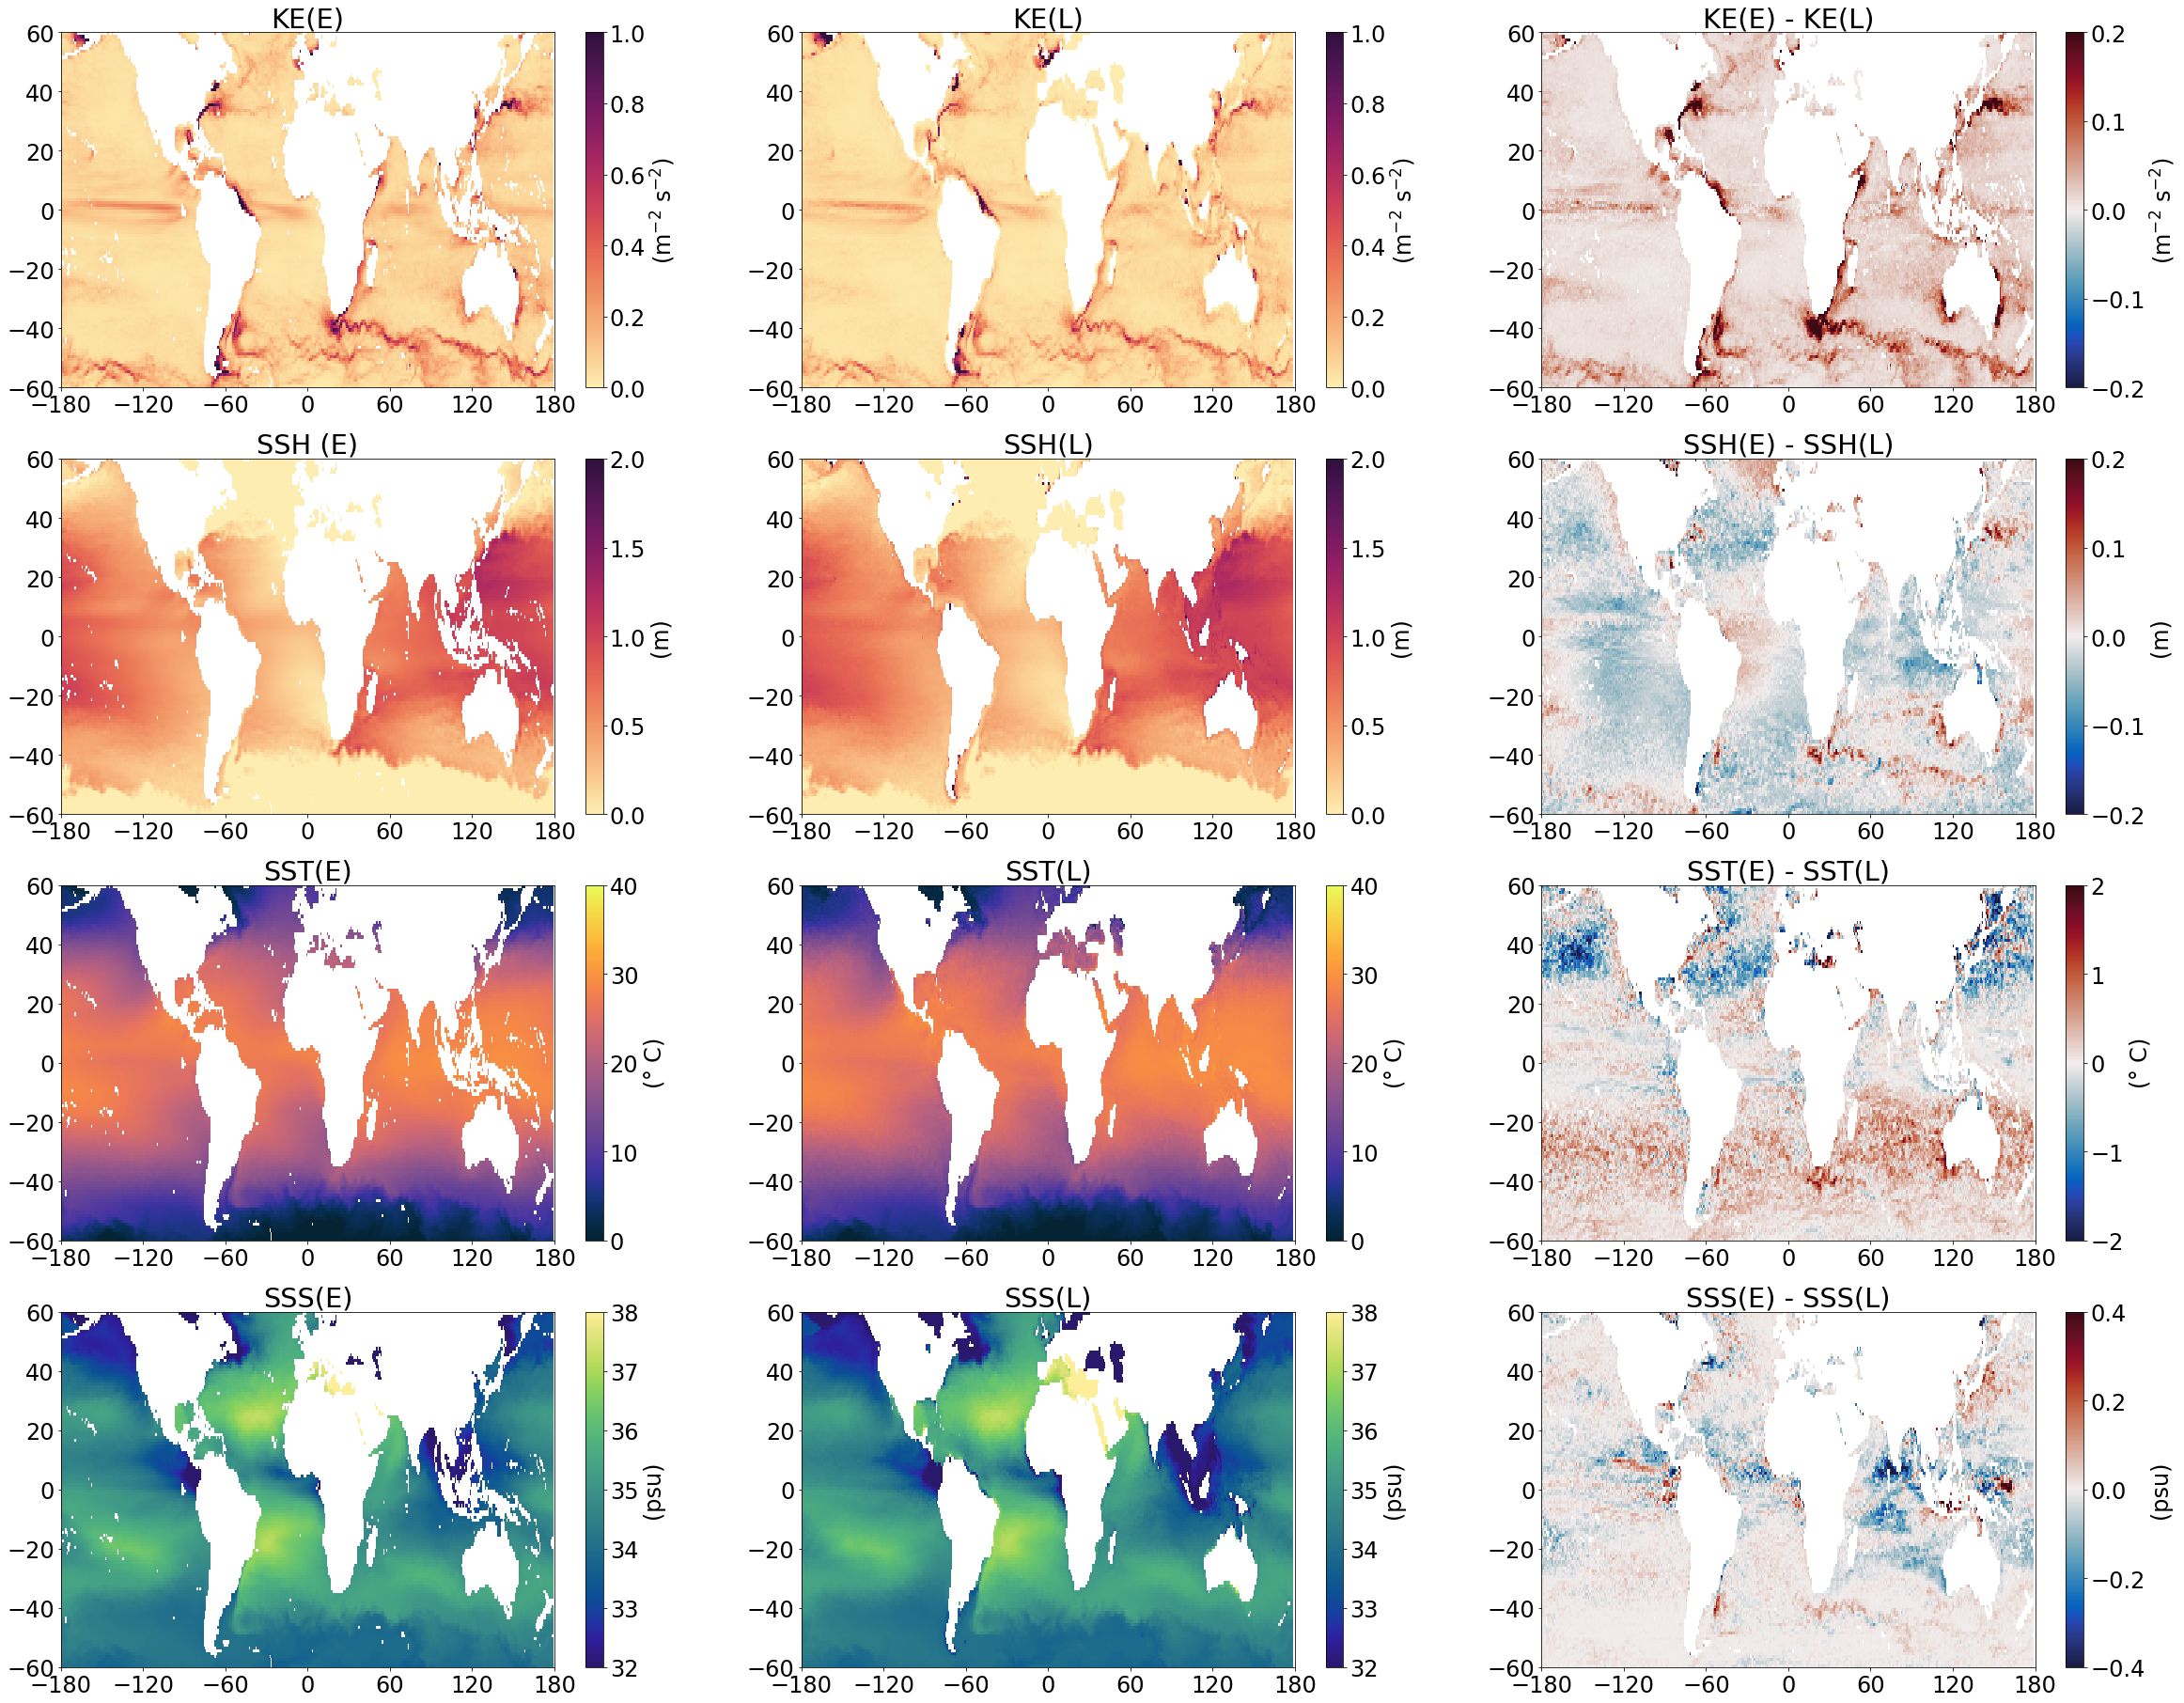

In [39]:
plt.rc('font', size=24) 
font_size=24
fig, ax = plt.subplots(figsize=(40,32))

# KE
ax = plt.subplot(431)
cax = (E.E_KE_mean).plot(x='lon',y='lat',vmin=0,vmax=1,cmap=cm.matter, add_colorbar = False)
cbar = plt.colorbar(cax, ax=ax, extend=None, orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('(m$^{-2}$ s$^{-2}$)', fontsize=font_size)
ax.set_xlim([-180,180])
ax.set_ylim([-60., 60.])
ax.set_xticks([-180, -120,-60, 0, 60, 120, 180])
ax.set_yticks([-60, -40, -20, 0, 20, 40, 60])
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_title('KE(E)')

ax = plt.subplot(432)
cax = (ds_L['velocity_amplitude_mean']**2).plot(x='lon',y='lat',vmin=0,vmax=1,cmap=cm.matter, add_colorbar = False)
cbar = plt.colorbar(cax, ax=ax, extend=None, orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('(m$^{-2}$ s$^{-2}$)', fontsize=font_size)
ax.set_xlim([-180,180])
ax.set_ylim([-60., 60.])
ax.set_xticks([-180, -120,-60, 0, 60, 120, 180])
ax.set_yticks([-60, -40, -20, 0, 20, 40, 60])
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_title('KE(L)')

ax = plt.subplot(433)
cax = (E.E_KE_mean - (ds_L['velocity_amplitude_mean']**2)).plot(x='lon',y='lat',vmin=-0.2,vmax=0.2,cmap=cm.balance, add_colorbar = False)
cbar = plt.colorbar(cax, ax=ax, extend=None, orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('(m$^{-2}$ s$^{-2}$)', fontsize=font_size)
ax.set_xlim([-180,180])
ax.set_ylim([-60., 60.])
ax.set_xticks([-180, -120,-60, 0, 60, 120, 180])
ax.set_yticks([-60, -40, -20, 0, 20, 40, 60])
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_title('KE(E) - KE(L)')


# SSH
ax = plt.subplot(434)
cax = (E.E_Eta_mean).plot(x='lon',y='lat',vmin=0,vmax=2,cmap=cm.matter, add_colorbar = False)
cbar = plt.colorbar(cax, ax=ax, extend=None, orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('(m)', fontsize=font_size)
ax.set_xlim([-180,180])
ax.set_ylim([-60., 60.])
ax.set_xticks([-180, -120,-60, 0, 60, 120, 180])
ax.set_yticks([-60, -40, -20, 0, 20, 40, 60])
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_title('SSH (E)')

ax = plt.subplot(435)
cax = ds_L['sea_level_mean'].plot(x='lon',y='lat',vmin=0,vmax=2,cmap=cm.matter, add_colorbar = False)
cbar = plt.colorbar(cax, ax=ax, extend=None, orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('(m)', fontsize=font_size)
ax.set_xlim([-180,180])
ax.set_ylim([-60., 60.])
ax.set_xticks([-180, -120,-60, 0, 60, 120, 180])
ax.set_yticks([-60, -40, -20, 0, 20, 40, 60])
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_title('SSH(L)')

ax = plt.subplot(436)
cax = ((E.E_Eta_mean) - ds_L['sea_level_mean']).plot(x='lon',y='lat',vmin=-0.2,vmax=0.2,cmap=cm.balance, add_colorbar = False)
cbar = plt.colorbar(cax, ax=ax, extend=None, orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('(m)', fontsize=font_size)
ax.set_xlim([-180,180])
ax.set_ylim([-60., 60.])
ax.set_xticks([-180, -120,-60, 0, 60, 120, 180])
ax.set_yticks([-60, -40, -20, 0, 20, 40, 60])
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_title('SSH(E) - SSH(L)')


# SST
ax = plt.subplot(437)
cax = (E.E_SST_mean).plot(x='lon',y='lat',vmin=0,vmax=40,cmap=cm.thermal, add_colorbar = False)
cbar = plt.colorbar(cax, ax=ax, extend=None, orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('($\degree$ C)', fontsize=font_size)
ax.set_xlim([-180,180])
ax.set_ylim([-60., 60.])
ax.set_xticks([-180, -120,-60, 0, 60, 120, 180])
ax.set_yticks([-60, -40, -20, 0, 20, 40, 60])
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_title('SST(E)')

ax = plt.subplot(438)
cax = ds_L['temperature_mean'].plot(x='lon',y='lat',vmin=0,vmax=40,cmap=cm.thermal, add_colorbar = False)
cbar = plt.colorbar(cax, ax=ax, extend=None, orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('($\degree$ C)', fontsize=font_size)
ax.set_xlim([-180,180])
ax.set_ylim([-60., 60.])
ax.set_xticks([-180, -120,-60, 0, 60, 120, 180])
ax.set_yticks([-60, -40, -20, 0, 20, 40, 60])
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_title('SST(L)')

ax = plt.subplot(439)
cax = ((E.E_SST_mean) - ds_L['temperature_mean']).plot(x='lon',y='lat',vmin=-2,vmax=2,cmap=cm.balance, add_colorbar = False)
cbar = plt.colorbar(cax, ax=ax, extend=None, orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('($\degree$ C)', fontsize=font_size)
ax.set_xlim([-180,180])
ax.set_ylim([-60., 60.])
ax.set_xticks([-180, -120,-60, 0, 60, 120, 180])
ax.set_yticks([-60, -40, -20, 0, 20, 40, 60])
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_title('SST(E) - SST(L)')


# SSS
ax = plt.subplot(4,3,10)
cax = (E.E_SSS_mean).plot(x='lon',y='lat',vmin=32,vmax=38,cmap=cm.haline, add_colorbar = False)
cbar = plt.colorbar(cax, ax=ax, extend=None, orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('(psu)', fontsize=font_size)
ax.set_xlim([-180,180])
ax.set_ylim([-60., 60.])
ax.set_xticks([-180, -120,-60, 0, 60, 120, 180])
ax.set_yticks([-60, -40, -20, 0, 20, 40, 60])
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_title('SSS(E)')

ax = plt.subplot(4,3,11)
cax = ds_L['salinity_mean'].plot(x='lon',y='lat',vmin=32,vmax=38,cmap=cm.haline, add_colorbar = False)
cbar = plt.colorbar(cax, ax=ax, extend=None, orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('(psu)', fontsize=font_size)
ax.set_xlim([-180,180])
ax.set_ylim([-60., 60.])
ax.set_xticks([-180, -120,-60, 0, 60, 120, 180])
ax.set_yticks([-60, -40, -20, 0, 20, 40, 60])
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_title('SSS(L)')

ax = plt.subplot(4,3,12)
cax = ((E.E_SSS_mean) - ds_L['salinity_mean']).plot(x='lon',y='lat',vmin=-0.4,vmax=0.4,cmap=cm.balance, add_colorbar = False)
cbar = plt.colorbar(cax, ax=ax, extend=None, orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('(psu)', fontsize=font_size)
ax.set_xlim([-180,180])
ax.set_ylim([-60., 60.])
ax.set_xticks([-180, -120,-60, 0, 60, 120, 180])
ax.set_yticks([-60, -40, -20, 0, 20, 40, 60])
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_title('SSS(E) - SSS(L)')

plt.savefig('/home1/datahome/xyu/equinox_working/Lagrangian_vs_Eulerian_LLC4320/Figures/Eulerian_vs_Lagrangian.png')

In [10]:
cluster.close()